Classification Report:
              precision    recall  f1-score   support

    negative       0.18      0.54      0.27       175
     neutral       0.42      0.06      0.10       622
    positive       0.34      0.51      0.41       372

    accuracy                           0.27      1169
   macro avg       0.31      0.37      0.26      1169
weighted avg       0.36      0.27      0.22      1169



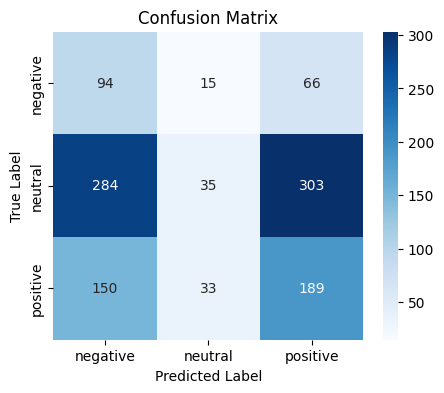

In [1]:
import re
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

def load_lexicon(file_path):
    lexicon = pd.read_csv(file_path, sep='\t', header=0, names=['word', 'weight'])
    lexicon['weight'] = pd.to_numeric(lexicon['weight'], errors='coerce')
    lexicon['length'] = lexicon['word'].apply(lambda x: len(x.split()))
    return lexicon.sort_values(by='length', ascending=False).reset_index(drop=True)

positive_lexicon = load_lexicon('positive.tsv')
negative_lexicon = load_lexicon('negative.tsv')

def calculate_sentiment(text, positive_lexicon, negative_lexicon):
    text = preprocess_text(text)
    sentiment_score = 0
    words = text.split()
    
    i = 0
    while i < len(words):
        matched = False
        for j in range(len(words), i, -1):
            phrase = ' '.join(words[i:j])
            
            pos_match = positive_lexicon[positive_lexicon['word'] == phrase]
            if not pos_match.empty:
                sentiment_score += pos_match.iloc[0]['weight']
                # Skip the matched words
                i = j - 1
                matched = True
                break
            
            neg_match = negative_lexicon[negative_lexicon['word'] == phrase]
            if not neg_match.empty:
                sentiment_score += neg_match.iloc[0]['weight']
                # Skip the matched words
                i = j - 1
                matched = True
                break
        if not matched:
            i += 1
        else:
            i += 1
    return sentiment_score

# 1. Load the same dataset
ds = load_dataset("rizr09/fin-dataset")
df = pd.DataFrame(ds['train'])

# 2. Perform the same data splitting
train_df, eval_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

# Rename columns
train_df = train_df.rename(columns={"text_clean": "text", "label": "label"})
eval_df = eval_df.rename(columns={"text_clean": "text", "label": "label"})

# Keep only necessary columns
train_df = train_df[['text', 'label']]
eval_df = eval_df[['text', 'label']]

# Reset index
train_df = train_df.reset_index(drop=True)
eval_df = eval_df.reset_index(drop=True)

# 3. Apply calculate_sentiment to the evaluation dataset
eval_df['Lexicon Sentiment Score'] = eval_df['text'].apply(
    lambda x: calculate_sentiment(x, positive_lexicon, negative_lexicon)
)

# 4. Map sentiment scores to labels
def sentiment_score_to_label(score):
    if score < 0:
        return 0  # negative
    elif score == 0:
        return 1  # neutral
    else:
        return 2  # positive

eval_df['Predicted Label'] = eval_df['Lexicon Sentiment Score'].apply(sentiment_score_to_label)

# 5. Generate the classification report
true_labels = eval_df['label']
predicted_labels = eval_df['Predicted Label']

# Define label mapping
label_mapping = {0: "negative", 1: "neutral", 2: "positive"}
target_names = [label_mapping[i] for i in sorted(label_mapping.keys())]

report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:")
print(report)

# 6. Generate and plot the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

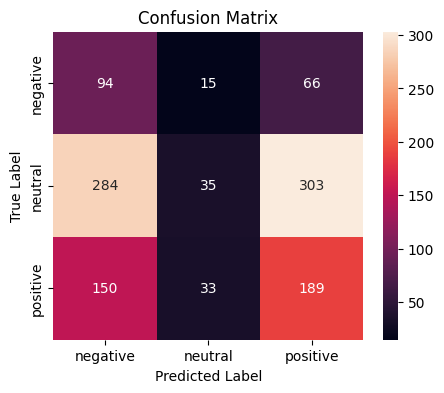

In [2]:
# 6. Generate and plot the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()